## TabNet installation

In [51]:
#!pip install pytorch-tabnet
!pip -q install /kaggle/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl
from pytorch_tabnet.tab_model import TabNetRegressor

## Libraries

In [52]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

## Feature Engineering

In [61]:
import pandas as pd
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test_ids = test["id"]
test = test.drop('id', axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

"""This Mapping Works Fine For me I also Check Each Values in Train and test Using Logic. There no Data Lekage."""

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

# Save processed train and test datasets to CSV
train.to_csv('/kaggle/working/processed_train.csv', index=False)
test.to_csv('/kaggle/working/processed_test.csv', index=False)

print("Processed data saved to CSV!")


100%|██████████| 2/2 [00:00<00:00,  7.75it/s]


Train Shape : (2736, 155) || Test Shape : (20, 154)
Processed data saved to CSV!


## Handling missing values

In [62]:
import pandas as pd
from sklearn.impute import KNNImputer

# Assuming `train` and `test` are your dataframes
# Define features dynamically
num_features = [f for f in train.columns if train[f].dtype in ['float64', 'int64']]
cat_features = [f for f in train.columns if f not in num_features]

# Exclude 'sii' (target) column from numerical features
if 'sii' in num_features:
    num_features.remove('sii')

print('The number of numerical features:', len(num_features))
print('The number of categorical features:', len(cat_features))

# Ensure the test set has all numerical and categorical features from train
missing_numerical_in_test = [col for col in train.columns if col not in test.columns and col in num_features]
for col in missing_numerical_in_test:
    test[col] = None  # Add missing numerical columns with NaN values

missing_categorical_in_test = [col for col in train.columns if col not in test.columns and col in cat_features]
for col in missing_categorical_in_test:
    test[col] = 'unknown'  # Add missing categorical columns with placeholder values

# Impute numerical features for train
imputer_num = KNNImputer(n_neighbors=2, weights="uniform")
train[num_features] = imputer_num.fit_transform(train[num_features])  # Fit and transform on train

# Use the same imputer for test
test[num_features] = imputer_num.transform(test[num_features])  # Transform on test

# Handle categorical features for train
for col in cat_features:
    train[col] = train[col].fillna('unknown')  # Fill missing values with 'unknown'
    train[col] = train[col].astype('category')  # Convert to categorical

# Handle categorical features for test
for col in cat_features:
    test[col] = test[col].fillna('unknown')  # Fill missing values with 'unknown'
    test[col] = test[col].astype('category')  # Convert to categorical

# Verify missing values in both datasets
print("Train missing values after imputation:", train.isnull().sum().sum())
print("Test missing values after imputation:", test.isnull().sum().sum())


The number of numerical features: 154
The number of categorical features: 0
Train missing values after imputation: 0
Test missing values after imputation: 0


In [4]:
train.shape

(2736, 155)

In [5]:
test.shape

(20, 154)

## Class Distribution

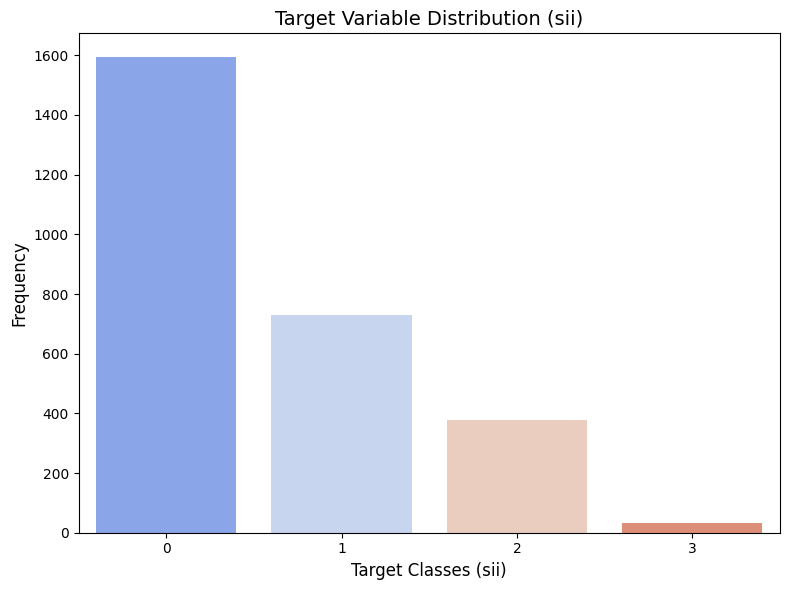

Target Class Distribution:
sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check target distribution in the training data
plt.figure(figsize=(8, 6))
sns.countplot(x=train['sii'], palette="coolwarm")
plt.title("Target Variable Distribution (sii)", fontsize=14)
plt.xlabel("Target Classes (sii)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=["0", "1", "2", "3"])
plt.tight_layout()
plt.show()

# Print exact counts of each class
print("Target Class Distribution:")
print(train['sii'].value_counts())


# Ensemble of TabNet classifiers
### Oversampling with Borderline-SMOTE
### Feature Scaling- StandardScaler 

In [8]:
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
import pandas as pd
import torch

# Split the dataset
X = train.drop(columns=["sii"])  # Features
y = train["sii"].astype(int)     # Target

# Split into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define a function to train a single TabNet model
def train_tabnet(X_train, X_valid, y_train, y_valid, tabnet_params, seed):
    # Oversample with Borderline-SMOTE
    oversampler = BorderlineSMOTE(random_state=seed)
    X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_valid_scaled = scaler.transform(X_valid)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # Train TabNet model
    tabnet_model = TabNetClassifier(**tabnet_params)
    tabnet_model.fit(
        X_train=X_train_scaled,
        y_train=y_train_balanced,
        eval_set=[(X_valid_scaled, y_valid.values)],
        eval_metric=['accuracy'],
        max_epochs=200,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )
    
    return tabnet_model, scaler

# Define ensemble parameters
n_models = 5  # Number of models in the ensemble
random_seeds = [42, 100, 202, 300, 404]  # Random seeds for each model
tabnet_params_list = [
    {  # Vary some hyperparameters for each model
        'n_d': 64,
        'n_a': 64,
        'n_steps': 5,
        'gamma': 1.5,
        'lambda_sparse': 1e-5,
        'optimizer_fn': torch.optim.AdamW,
        'optimizer_params': dict(lr=2e-2, weight_decay=1e-3),
        'mask_type': 'entmax',
        'verbose': 1,
        'device_name': 'cuda' if torch.cuda.is_available() else 'cpu',
    } for _ in range(n_models)
]

# Train multiple models
models = []
scalers = []

for i, seed in enumerate(random_seeds):
    print(f"\nTraining model {i+1}/{n_models} with seed {seed}")
    tabnet_model, scaler = train_tabnet(X_train, X_valid, y_train, y_valid, tabnet_params_list[i], seed)
    models.append(tabnet_model)
    scalers.append(scaler)

# Ensemble predictions
def ensemble_predictions(models, scalers, X_valid, weights=None):
    weights = weights if weights else [1] * len(models)  # Default weights to 1
    predictions = []
    for i, (model, scaler) in enumerate(zip(models, scalers)):
        X_valid_scaled = scaler.transform(X_valid)
        pred = model.predict(X_valid_scaled)
        predictions.append(weights[i] * pred)
    return np.round(np.sum(predictions, axis=0) / sum(weights)).astype(int)

# Validate ensemble model
y_val_pred_ensemble = ensemble_predictions(models, scalers, X_valid)

# Evaluate Performance
mse = mean_squared_error(y_valid, y_val_pred_ensemble)
precision = precision_score(y_valid, y_val_pred_ensemble, average='weighted')
recall = recall_score(y_valid, y_val_pred_ensemble, average='weighted')
f1 = f1_score(y_valid, y_val_pred_ensemble, average='weighted')

# Define Quadratic Weighted Kappa (QWK)
def quadratic_weighted_kappa(y_true, y_pred, num_classes):
    O = np.zeros((num_classes, num_classes), dtype=np.float32)
    for a, p in zip(y_true, y_pred):
        O[int(a), int(p)] += 1
    W = np.zeros((num_classes, num_classes), dtype=np.float32)
    for i in range(num_classes):
        for j in range(num_classes):
            W[i, j] = ((i - j) ** 2) / ((num_classes - 1) ** 2)
    actual_hist = np.sum(O, axis=1)
    pred_hist = np.sum(O, axis=0)
    E = np.outer(actual_hist, pred_hist) / np.sum(O)
    numerator = np.sum(W * O)
    denominator = np.sum(W * E)
    return 1 - (numerator / denominator)

qwk_val = quadratic_weighted_kappa(y_valid, y_val_pred_ensemble, num_classes=4)

# Print Results
print(f"Validation MSE: {mse:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Quadratic Weighted Kappa (QWK): {qwk_val:.4f}")

# Test predictions and submission
test_scaled = scalers[0].transform(test)  # Use the first scaler to scale test data
test_predictions = ensemble_predictions(models, scalers, test)  # Use ensemble predictions

# Create a submission DataFrame
submission = pd.DataFrame({
    "id": test_ids,  # Replace `test_ids` with the appropriate column containing test sample IDs
    "sii": test_predictions
})

# Save the submission file
submission.to_csv("submission.csv", index=False)
print("Submission file saved as 'submission.csv'")
print(submission.head())



Training model 1/5 with seed 42
epoch 0  | loss: 2.25386 | val_0_accuracy: 0.38686 |  0:00:01s
epoch 1  | loss: 1.54127 | val_0_accuracy: 0.33029 |  0:00:02s
epoch 2  | loss: 1.24197 | val_0_accuracy: 0.40146 |  0:00:04s
epoch 3  | loss: 1.06234 | val_0_accuracy: 0.39599 |  0:00:05s
epoch 4  | loss: 1.01911 | val_0_accuracy: 0.36314 |  0:00:06s
epoch 5  | loss: 0.9734  | val_0_accuracy: 0.42336 |  0:00:07s
epoch 6  | loss: 0.90061 | val_0_accuracy: 0.40693 |  0:00:08s
epoch 7  | loss: 0.88017 | val_0_accuracy: 0.39599 |  0:00:10s
epoch 8  | loss: 0.85168 | val_0_accuracy: 0.44343 |  0:00:11s
epoch 9  | loss: 0.82041 | val_0_accuracy: 0.45073 |  0:00:13s
epoch 10 | loss: 0.79805 | val_0_accuracy: 0.41606 |  0:00:14s
epoch 11 | loss: 0.76378 | val_0_accuracy: 0.42701 |  0:00:15s
epoch 12 | loss: 0.72938 | val_0_accuracy: 0.48723 |  0:00:16s
epoch 13 | loss: 0.71811 | val_0_accuracy: 0.47445 |  0:00:17s
epoch 14 | loss: 0.69675 | val_0_accuracy: 0.51095 |  0:00:19s
epoch 15 | loss: 0.682

     Model       MSE  Precision    Recall        F1       QWK
0  Model 1  0.782847   0.546443  0.556569  0.550681  0.350409
1  Model 2  0.718978   0.564242  0.572993  0.567276  0.396243
2  Model 3  0.844891   0.544701  0.525547  0.532020  0.361019
3  Model 4  0.813869   0.533424  0.562044  0.538985  0.348791
4  Model 5  0.874088   0.518819  0.545620  0.523954  0.304502


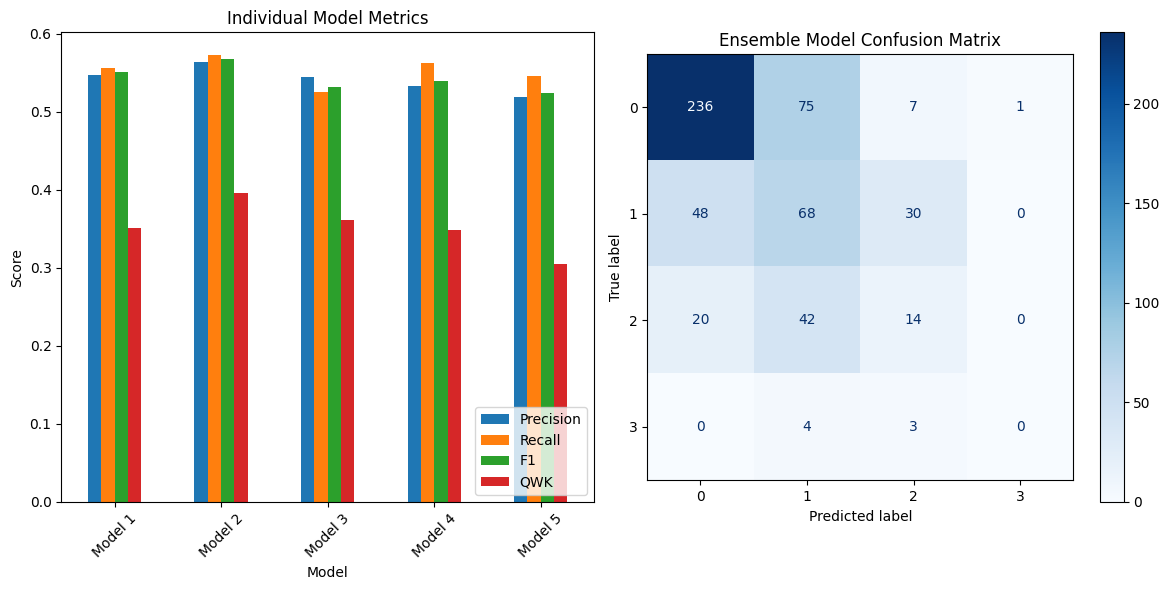

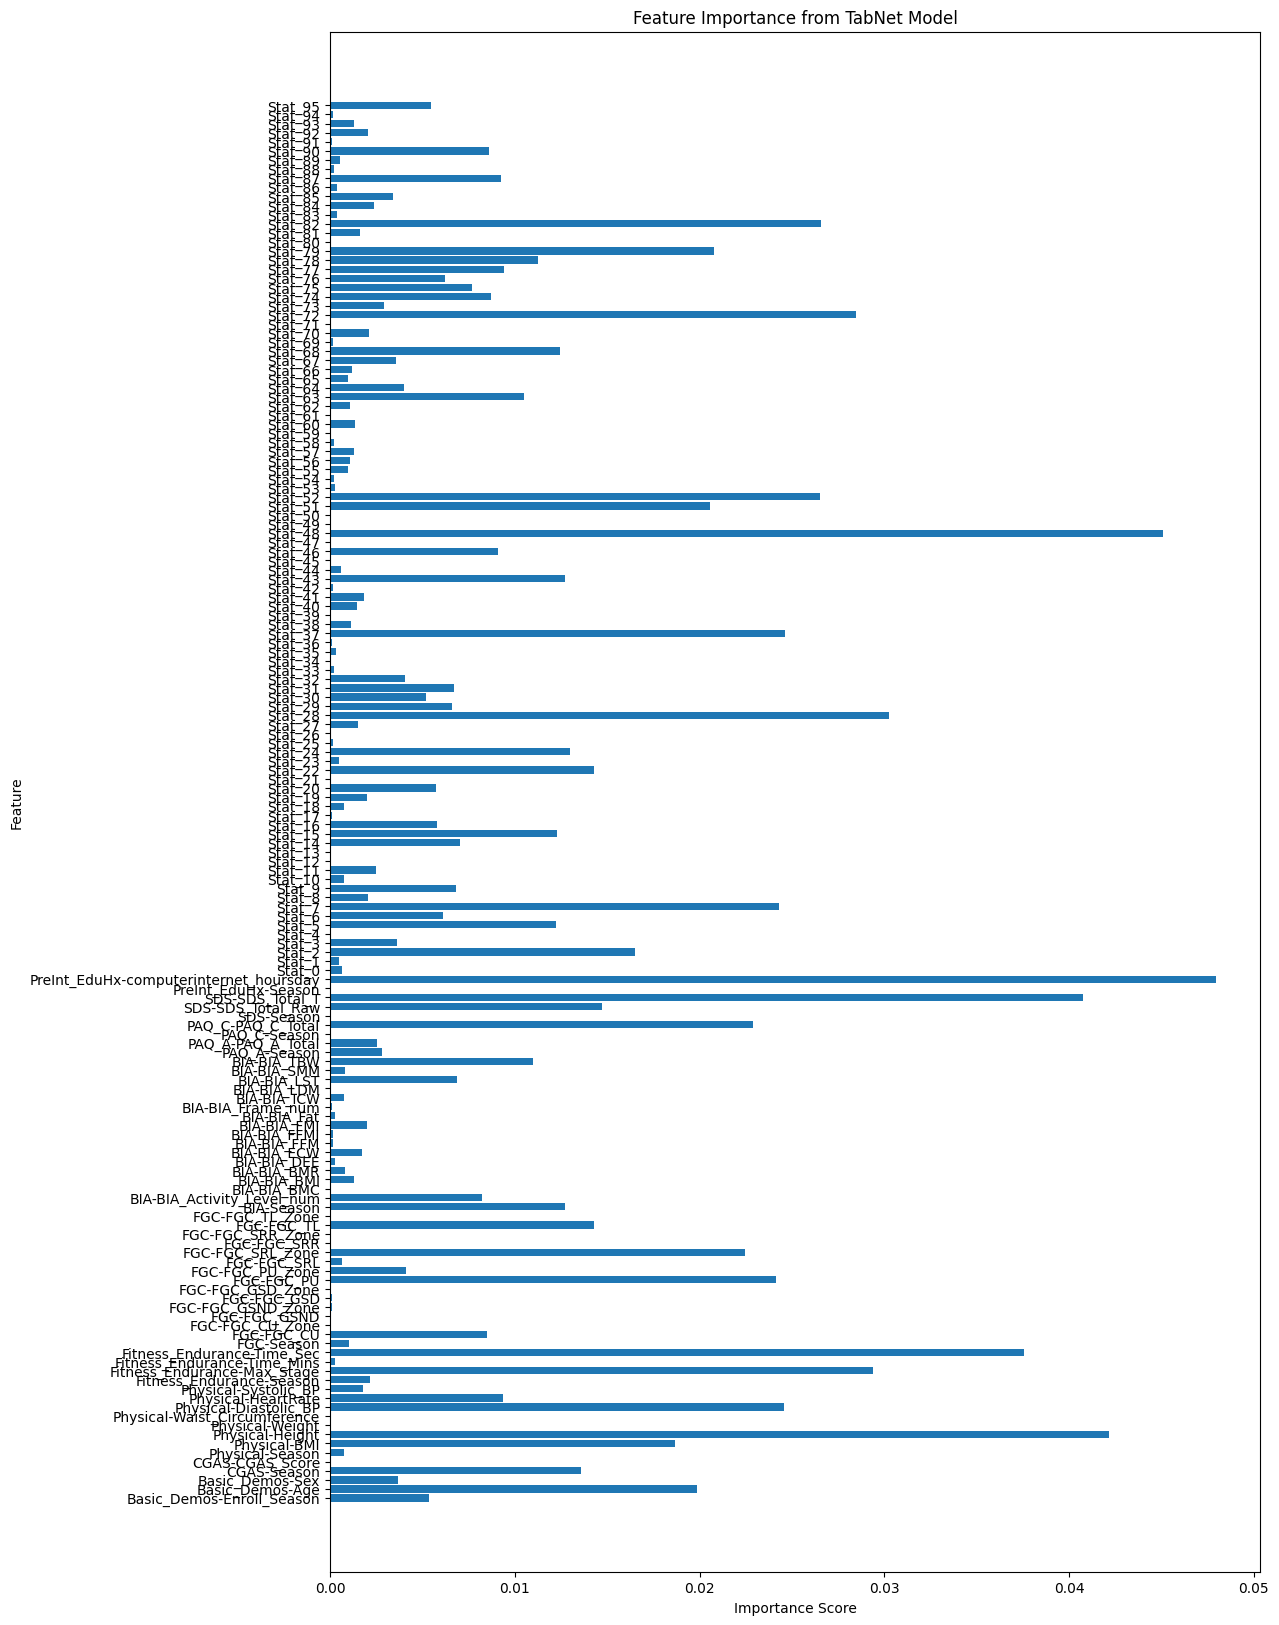

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualization: Performance metrics for individual models
model_metrics = []

for i, model in enumerate(models):
    X_valid_scaled = scalers[i].transform(X_valid)
    y_pred = model.predict(X_valid_scaled)
    mse = mean_squared_error(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, average='weighted')
    recall = recall_score(y_valid, y_pred, average='weighted')
    f1 = f1_score(y_valid, y_pred, average='weighted')
    qwk = quadratic_weighted_kappa(y_valid, y_pred, num_classes=4)
    
    model_metrics.append({
        'Model': f"Model {i+1}",
        'MSE': mse,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'QWK': qwk,
    })

# Convert metrics to DataFrame for easy visualization
metrics_df = pd.DataFrame(model_metrics)
print(metrics_df)

# Plot metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot individual model metrics
metrics_df.plot(x='Model', y=['Precision', 'Recall', 'F1', 'QWK'], kind='bar', ax=ax[0])
ax[0].set_title('Individual Model Metrics')
ax[0].set_ylabel('Score')
ax[0].set_xticklabels(metrics_df['Model'], rotation=45)
ax[0].legend(loc='lower right')

# Confusion Matrix for Ensemble Model
ensemble_cm = confusion_matrix(y_valid, y_val_pred_ensemble)
disp = ConfusionMatrixDisplay(confusion_matrix=ensemble_cm)
disp.plot(ax=ax[1], cmap='Blues')
ax[1].set_title('Ensemble Model Confusion Matrix')

plt.tight_layout()
plt.show()

# Plot feature importance from the first TabNet model
feature_importances = models[0].feature_importances_
plt.figure(figsize=(12, 20))
plt.barh(X.columns, feature_importances)
plt.title('Feature Importance from TabNet Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Training Fold 1...
epoch 0  | loss: 1.94983 | val_0_logloss: 1.3356  |  0:00:01s
epoch 1  | loss: 1.51017 | val_0_logloss: 1.22148 |  0:00:02s
epoch 2  | loss: 1.40013 | val_0_logloss: 1.55422 |  0:00:03s
epoch 3  | loss: 1.29485 | val_0_logloss: 1.22306 |  0:00:04s
epoch 4  | loss: 1.22854 | val_0_logloss: 1.36359 |  0:00:05s
epoch 5  | loss: 1.13308 | val_0_logloss: 1.16633 |  0:00:06s
epoch 6  | loss: 1.10117 | val_0_logloss: 1.33064 |  0:00:06s
epoch 7  | loss: 1.05484 | val_0_logloss: 1.24824 |  0:00:07s
epoch 8  | loss: 1.04105 | val_0_logloss: 1.35038 |  0:00:09s
epoch 9  | loss: 0.99972 | val_0_logloss: 1.24173 |  0:00:10s
epoch 10 | loss: 0.9663  | val_0_logloss: 1.15997 |  0:00:11s
epoch 11 | loss: 0.96518 | val_0_logloss: 1.17894 |  0:00:12s
epoch 12 | loss: 0.94449 | val_0_logloss: 1.136   |  0:00:13s
epoch 13 | loss: 0.94473 | val_0_logloss: 1.16047 |  0:00:14s
epoch 14 | loss: 0.93724 | val_0_logloss: 1.16932 |  0:00:15s
epoch 15 | loss: 0.90638 | val_0_logloss: 1.0953  |

Training Folds:  20%|██        | 1/5 [00:58<03:53, 58.44s/it]

Training Fold 2...
epoch 0  | loss: 2.50132 | val_0_logloss: 1.53224 |  0:00:01s
epoch 1  | loss: 1.62554 | val_0_logloss: 1.38877 |  0:00:02s
epoch 2  | loss: 1.26721 | val_0_logloss: 1.52216 |  0:00:04s
epoch 3  | loss: 1.10319 | val_0_logloss: 1.37051 |  0:00:05s
epoch 4  | loss: 1.0163  | val_0_logloss: 1.40287 |  0:00:06s
epoch 5  | loss: 0.96663 | val_0_logloss: 1.54258 |  0:00:08s
epoch 6  | loss: 0.9275  | val_0_logloss: 1.39123 |  0:00:09s
epoch 7  | loss: 0.89235 | val_0_logloss: 1.34907 |  0:00:10s
epoch 8  | loss: 0.89923 | val_0_logloss: 1.2282  |  0:00:11s
epoch 9  | loss: 0.85237 | val_0_logloss: 1.41476 |  0:00:13s
epoch 10 | loss: 0.8285  | val_0_logloss: 1.34485 |  0:00:14s
epoch 11 | loss: 0.78497 | val_0_logloss: 1.1255  |  0:00:15s
epoch 12 | loss: 0.74371 | val_0_logloss: 1.27729 |  0:00:17s
epoch 13 | loss: 0.71427 | val_0_logloss: 1.18269 |  0:00:18s
epoch 14 | loss: 0.70172 | val_0_logloss: 1.17435 |  0:00:19s
epoch 15 | loss: 0.6689  | val_0_logloss: 1.19744 |

Training Folds:  40%|████      | 2/5 [01:41<02:28, 49.45s/it]

Training Fold 3...
epoch 0  | loss: 2.3202  | val_0_logloss: 1.72183 |  0:00:01s
epoch 1  | loss: 1.40236 | val_0_logloss: 1.44656 |  0:00:02s
epoch 2  | loss: 1.22441 | val_0_logloss: 1.54614 |  0:00:03s
epoch 3  | loss: 1.093   | val_0_logloss: 1.4203  |  0:00:05s
epoch 4  | loss: 1.05558 | val_0_logloss: 1.41464 |  0:00:06s
epoch 5  | loss: 1.06007 | val_0_logloss: 1.44326 |  0:00:07s
epoch 6  | loss: 0.99708 | val_0_logloss: 1.28504 |  0:00:09s
epoch 7  | loss: 0.93395 | val_0_logloss: 1.30721 |  0:00:10s
epoch 8  | loss: 0.82507 | val_0_logloss: 1.1519  |  0:00:11s
epoch 9  | loss: 0.84771 | val_0_logloss: 1.26316 |  0:00:13s
epoch 10 | loss: 0.81022 | val_0_logloss: 1.27112 |  0:00:14s
epoch 11 | loss: 0.77968 | val_0_logloss: 1.15621 |  0:00:15s
epoch 12 | loss: 0.76546 | val_0_logloss: 1.1703  |  0:00:16s
epoch 13 | loss: 0.74901 | val_0_logloss: 1.14841 |  0:00:18s
epoch 14 | loss: 0.73412 | val_0_logloss: 1.24772 |  0:00:19s
epoch 15 | loss: 0.71416 | val_0_logloss: 1.30084 |

Training Folds:  60%|██████    | 3/5 [02:30<01:38, 49.03s/it]

Training Fold 4...
epoch 0  | loss: 2.24385 | val_0_logloss: 1.55927 |  0:00:01s
epoch 1  | loss: 1.42353 | val_0_logloss: 1.39305 |  0:00:02s
epoch 2  | loss: 1.23711 | val_0_logloss: 1.28983 |  0:00:03s
epoch 3  | loss: 1.1302  | val_0_logloss: 1.56146 |  0:00:05s
epoch 4  | loss: 1.06675 | val_0_logloss: 1.42591 |  0:00:06s
epoch 5  | loss: 0.95085 | val_0_logloss: 1.30672 |  0:00:07s
epoch 6  | loss: 0.94535 | val_0_logloss: 1.303   |  0:00:08s
epoch 7  | loss: 0.91657 | val_0_logloss: 1.30735 |  0:00:10s
epoch 8  | loss: 0.89849 | val_0_logloss: 1.32963 |  0:00:11s
epoch 9  | loss: 0.86467 | val_0_logloss: 1.15389 |  0:00:12s
epoch 10 | loss: 0.86883 | val_0_logloss: 1.23829 |  0:00:13s
epoch 11 | loss: 0.79198 | val_0_logloss: 1.15514 |  0:00:15s
epoch 12 | loss: 0.75447 | val_0_logloss: 1.22409 |  0:00:16s
epoch 13 | loss: 0.73736 | val_0_logloss: 1.23504 |  0:00:17s
epoch 14 | loss: 0.73222 | val_0_logloss: 1.18336 |  0:00:18s
epoch 15 | loss: 0.70687 | val_0_logloss: 1.15531 |

Training Folds:  80%|████████  | 4/5 [03:22<00:50, 50.54s/it]

Training Fold 5...
epoch 0  | loss: 2.29514 | val_0_logloss: 1.39093 |  0:00:01s
epoch 1  | loss: 1.44819 | val_0_logloss: 1.34871 |  0:00:02s
epoch 2  | loss: 1.18508 | val_0_logloss: 1.33939 |  0:00:04s
epoch 3  | loss: 1.04933 | val_0_logloss: 1.36215 |  0:00:06s
epoch 4  | loss: 0.96101 | val_0_logloss: 1.35364 |  0:00:07s
epoch 5  | loss: 0.93427 | val_0_logloss: 1.37236 |  0:00:08s
epoch 6  | loss: 0.90557 | val_0_logloss: 1.26969 |  0:00:09s
epoch 7  | loss: 0.91032 | val_0_logloss: 1.26552 |  0:00:11s
epoch 8  | loss: 0.87697 | val_0_logloss: 1.15118 |  0:00:12s
epoch 9  | loss: 0.85776 | val_0_logloss: 1.12185 |  0:00:13s
epoch 10 | loss: 0.83431 | val_0_logloss: 1.10369 |  0:00:15s
epoch 11 | loss: 0.8145  | val_0_logloss: 1.18157 |  0:00:16s
epoch 12 | loss: 0.79987 | val_0_logloss: 1.12231 |  0:00:17s
epoch 13 | loss: 0.77288 | val_0_logloss: 1.19207 |  0:00:19s
epoch 14 | loss: 0.74555 | val_0_logloss: 1.14901 |  0:00:20s
epoch 15 | loss: 0.72758 | val_0_logloss: 1.14556 |

Training Folds: 100%|██████████| 5/5 [04:19<00:00, 51.97s/it]


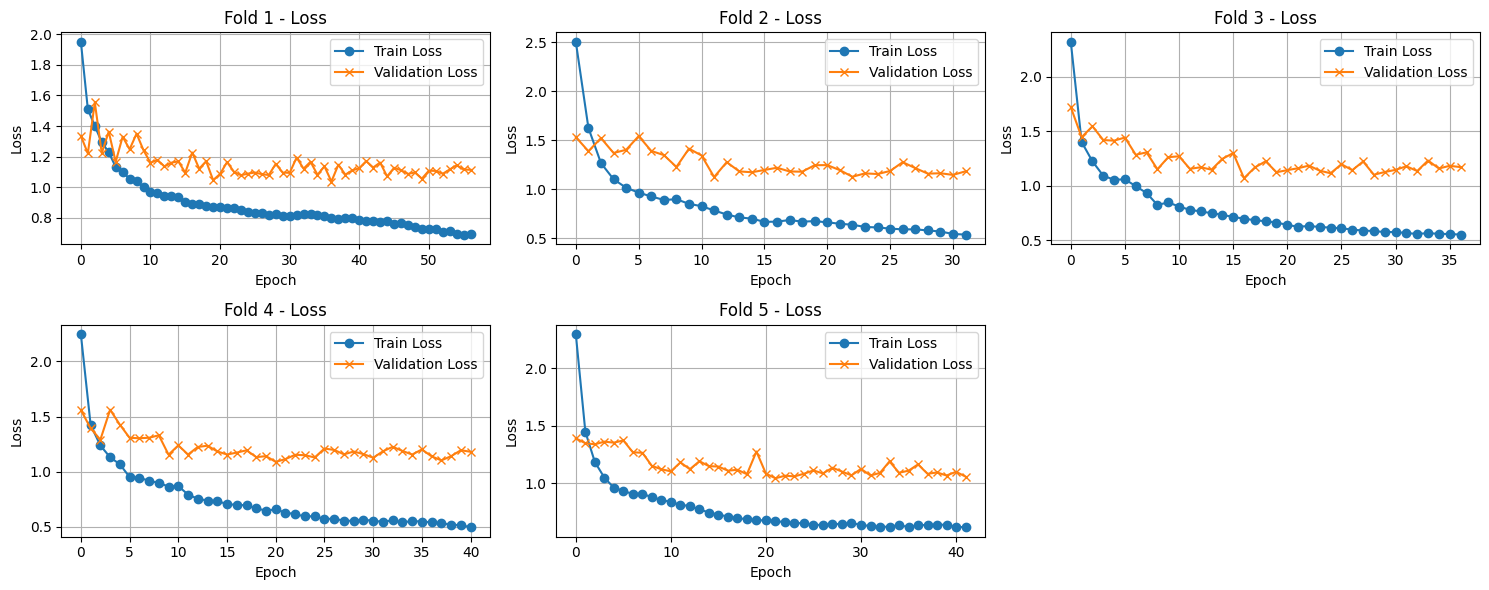

Validation MSE: 0.6296
Precision: 0.5810
Recall: 0.6095
F1 Score: 0.5824
Quadratic Weighted Kappa (QWK): 0.3364
Submission file saved as 'submission.csv'


In [78]:
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Split the dataset
X = train.drop(columns=["sii"])  # Features
y = train["sii"].astype(int)     # Target

# Define TabNet training function
def train_tabnet(X_train, X_valid, y_train, y_valid, tabnet_params):
    # Oversample with Borderline-SMOTE
    oversampler = BorderlineSMOTE(random_state=42)
    X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_valid_scaled = scaler.transform(X_valid)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # Train TabNet model
    tabnet_model = TabNetClassifier(**tabnet_params)
    tabnet_model.fit(
        X_train=X_train_scaled,
        y_train=y_train_balanced,
        eval_set=[(X_valid_scaled, y_valid.values)],
        eval_metric=['logloss'],
        max_epochs=200,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )
    
    return tabnet_model, scaler

# Define TabNet parameters
tabnet_params = {
    'n_d': 64,
    'n_a': 64,
    'n_steps': 5,
    'gamma': 1.5,
    'lambda_sparse': 1e-5,
    'optimizer_fn': torch.optim.AdamW,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-3),
    'mask_type': 'entmax',
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu',
}

# Define the TrainML function
def TrainML(model_class, test_data):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    loss_history = {'train_loss': {}, 'validation_loss': {}}

    for fold, (train_idx, validation_idx) in enumerate(
        tqdm(skf.split(X, y), desc="Training Folds", total=5)
    ):
        X_train, X_valid = X.iloc[train_idx], X.iloc[validation_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[validation_idx]

        print(f"Training Fold {fold + 1}...")
        tabnet_model, scaler = train_tabnet(X_train, X_valid, y_train, y_valid, tabnet_params)

        # Log losses
        loss_history['train_loss'][fold + 1] = tabnet_model.history['loss']
        loss_history['validation_loss'][fold + 1] = tabnet_model.history['val_0_logloss']

    return loss_history

# Define the plotting function
def plot_tabnet_losses_compact(loss_history):
    """
    Plot train and validation losses for each fold in a compact 2-row grid layout.
    """
    num_folds = len(loss_history['train_loss'])
    cols = (num_folds + 1) // 2  # Two rows, calculate columns dynamically

    fig, axes = plt.subplots(2, cols, figsize=(5 * cols, 6))  # Adjust figure size for compactness
    axes = axes.flatten()  # Flatten axes for easy iteration

    for i, (fold, train_loss) in enumerate(loss_history['train_loss'].items()):
        ax = axes[i]
        ax.plot(train_loss, label='Train Loss', marker='o')
        ax.plot(loss_history['validation_loss'][fold], label='Validation Loss', marker='x')
        ax.set_title(f'Fold {fold} - Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Train the model and generate loss history
ensemble_1_metrics = TrainML(tabnet_params, test)

# Plot the losses
plot_tabnet_losses_compact(ensemble_1_metrics)

# Generate predictions (if needed)
# Use the trained models for predictions and further evaluation as required
# Ensemble predictions
def ensemble_predictions(models, scalers, X_valid):
    """
    Generate ensemble predictions from multiple TabNet models.
    """
    predictions = []
    for model, scaler in zip(models, scalers):
        X_valid_scaled = scaler.transform(X_valid)
        predictions.append(model.predict(X_valid_scaled))
    return np.mean(predictions, axis=0).astype(int)

# Generate ensemble predictions on the validation set
y_val_pred_ensemble = ensemble_predictions(models, scalers, X_valid)

# Define Quadratic Weighted Kappa (QWK)
def quadratic_weighted_kappa(y_true, y_pred, num_classes):
    """
    Calculate the Quadratic Weighted Kappa (QWK) score.
    """
    O = np.zeros((num_classes, num_classes), dtype=np.float32)
    for a, p in zip(y_true, y_pred):
        O[int(a), int(p)] += 1
    W = np.zeros((num_classes, num_classes), dtype=np.float32)
    for i in range(num_classes):
        for j in range(num_classes):
            W[i, j] = ((i - j) ** 2) / ((num_classes - 1) ** 2)
    actual_hist = np.sum(O, axis=1)
    pred_hist = np.sum(O, axis=0)
    E = np.outer(actual_hist, pred_hist) / np.sum(O)
    numerator = np.sum(W * O)
    denominator = np.sum(W * E)
    return 1 - (numerator / denominator)

# Evaluate performance
qwk_val = quadratic_weighted_kappa(y_valid, y_val_pred_ensemble, num_classes=4)
mse = mean_squared_error(y_valid, y_val_pred_ensemble)
precision = precision_score(y_valid, y_val_pred_ensemble, average='weighted')
recall = recall_score(y_valid, y_val_pred_ensemble, average='weighted')
f1 = f1_score(y_valid, y_val_pred_ensemble, average='weighted')

# Print evaluation results
print(f"Validation MSE: {mse:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Quadratic Weighted Kappa (QWK): {qwk_val:.4f}")
# Scale the test data using the first model's scaler
test_scaled = scalers[0].transform(test)

# Generate predictions on the test set using the ensemble
test_predictions = ensemble_predictions(models, scalers, test)

# Create a submission DataFrame
submission = pd.DataFrame({
    "id": test_ids,  # Replace `test_ids` with the appropriate column containing test sample IDs
    "sii": test_predictions
})

# Save the submission file
submission.to_csv("submission.csv", index=False)
print("Submission file saved as 'submission.csv'")
